# Экспорт статей из ArXiv.org
В данной тетрадке реализован подход, позволяющий загружать статьи (исходники и pdf) из [arXiv.org](https://arxiv.org) через arXiv API. Сначала будут получены метаданные статей (id, название, ссылки на скачивание), а потом произведена загрузка документов на диск. 


## Источники
При создании этого документа использовались следующие источники:

1. [python_arXiv_parsing_example](https://arxiv.org/help/api/examples/python_arXiv_parsing_example.txt)  
2. [python_arXiv_paging_example](https://arxiv.org/help/api/examples/python_arXiv_paging_example.txt)  
3. [arXiv API User's Manual](https://arxiv.org/help/api/user-manual#_feed_metadata)
4. [KDD Cap 2003 - Datasets](http://www.cs.cornell.edu/projects/kddcup/datasets.html)

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import csv
import urllib
import urllib.request as request
from urllib.request import urlretrieve
import feedparser
import time
import os
import re

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

Загружаем все категории arXiv`a. Информация о категориях расположена на [этой](https://arxiv.org/help/api/user-manual#_feed_metadata) странице. Список категорий (аббревиатура и расшифровка) сохраним как DataFrame в файл [subject_classifications.csv](https://drive.google.com/open?id=0B_NefGKQ1pCsMlRwQThKdVpBdnM).

In [2]:
path = "D:/_data_science/@@projects/2017_diploma-nlp/data/"

subjects = pd.read_csv(path + "subject_classifications.csv", sep=';')
abbreviations = subjects["Subject Abbreviation"]
description = subjects["Description"]
subjects_dictionary = dict(zip(abbreviations, description))

print(subjects.shape)
subjects.head()

(127, 2)


,Subject Abbreviation,Description
0,stat.AP,Statistics - Applications
1,stat.CO,Statistics - Computation
2,stat.ML,Statistics - Machine Learning
3,stat.ME,Statistics - Methodology
4,stat.TH,Statistics - Theory


## Выполнение и обработка запросов

In [ ]:
def queries(search_query='cs.OS', start = 0, max_results = 5, path=path, is_new=False):
    '''
    Description
    
    '''
    # Base api query url
    base_url = 'http://export.arxiv.org/api/query?'

    # Opensearch metadata such as totalResults, startIndex, 
    # and itemsPerPage live in the opensearch namespase.
    # Some entry metadata lives in the arXiv namespace.
    # This is a hack to expose both of these namespaces in 
    #feedparser v4.1
    feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
    feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

    # perform a GET request using the base_url and query
    query = 'search_query=%s&start=%i&max_results=%i' % (search_query, 0, 1)
    response = request.urlopen(base_url + query).read()

    # parse the response using feedparser
    feed = feedparser.parse(response)
    
    # nubmer of all articles for search_query
    totalResults = int(feed.feed.opensearch_totalresults.split('totalResults for this query: ')[0])
    
    # Search parameters
    total_results = totalResults                 # want all total results
    results_per_iteration = 500                  # 500 results at a time
    wait_time = 3                                # number of seconds to wait beetween calls
    
    
    print('Searching arXiv for %s' % subjects_dictionary[search_query])
    print("Number of documents: %d" % totalResults)
    
    # We will writing metadata to csv-file
    result = path + 'queries.csv'
    names = ['id','title', 'primary_category', 'category', 'source_link', 'pdf_link']
    if is_new:
        f = open(result, "w+")
        f.close()
        
    f = open(result, 'a+')
    writer = csv.DictWriter(f, fieldnames=names)
    if os.stat(result).st_size == 0:
        writer.writeheader()
    
    for i in range(start, total_results, results_per_iteration):
        #print("Results %i - %i" % (i, i + results_per_iteration))
        query = 'search_query=%s&start=%i&max_results=%i' % (search_query, i, results_per_iteration)
        
        # perform a GET request using the base_url and query
        response = request.urlopen(base_url + query).read()

        # parse the response using feedparser
        feed = feedparser.parse(response)

        # Run through each entry, and print out information
        for entry in feed.entries:
            arxiv_id = entry.id.split('/abs/')[-1]
            title = entry.title
            
            # Get primary category
            primary_category = entry.arxiv_primary_category['term']
            
            # Lets get all the categories
            all_categories = [t['term'] for t in entry.tags]
            
            # get the links to the abs page and pdf for this e-print
            for link in entry.links:
                if link.rel == 'alternate':
                    source_link = link.href.replace('abs','e-print')
                elif link.title == 'pdf':
                    pdf_link = link.href
            
            try:
                writer.writerow({'id': arxiv_id,
                             'title': title,
                             'primary_category': primary_category,
                             'category': all_categories,
                             'source_link': source_link,
                             'pdf_link': pdf_link})
            except UnicodeEncodeError:
                continue
            
        # Remember to play nice and sleep a bit before you call the api again!
        time.sleep(wait_time)

Теперь получим метаданные для всех документов каждой категории и запишем результат в файл.

In [ ]:
%%time

%time queries(search_query=abbreviations[0], is_new=True)
print("\n")

for cat in abbreviations[1:] :
    %time queries(search_query=cat)
    print("\n")

>**Внимание!**  
Общее время работы составляет около **13 часов** на ноутбуке Lenovo U410 (Intel Core i3). [Ссылка](https://drive.google.com/open?id=0B_NefGKQ1pCsaXpDc2doak1xY0E) на архив с файлом.

## Анализ метаданных

In [3]:
queries = pd.read_csv(path + "queries.csv", encoding='cp1251')
queries.tail()

,id,title,primary_category,category,source_link,pdf_link
1363562,1507.00104v1,Geometric Class Field Theory,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00104v1,http://arxiv.org/pdf/1507.00104v1
1363563,1507.00254v2,The Crepant Transformation Conjecture implies ...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00254v2,http://arxiv.org/pdf/1507.00254v2
1363564,1507.00573v1,Comparison results for derived Deligne-Mumford...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00573v1,http://arxiv.org/pdf/1507.00573v1
1363565,1507.00624v1,Duality for dormant opers,math.AG,"['math.AG', 'math.RT']",http://arxiv.org/e-print/1507.00624v1,http://arxiv.org/pdf/1507.00624v1
1363566,1507.00952v1,A new proof of the Caporaso-Sernesi theorem vi...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00952v1,http://arxiv.org/pdf/1507.00952v1


Получился файл, содержащий более миллиона записей. Проверим нет ли повторяющихся записей в данной таблице.

In [4]:
n = len(queries)
m = len(queries.drop_duplicates())
print("Number of all queries: %d" % n)
print("Number of unique queries: %d" % m)
print("Duplicates: %d" % (n - m))

Number of all queries: 1363567
Number of unique queries: 937577
Duplicates: 425990


Удаляем дубли из таблицы

In [5]:
queries.drop_duplicates(inplace=True)
queries.set_index(queries['id'], inplace=True)
del queries['id']

Посмотрим как распределяются категории. Построим гистограмму распределения частот всех категорий. 

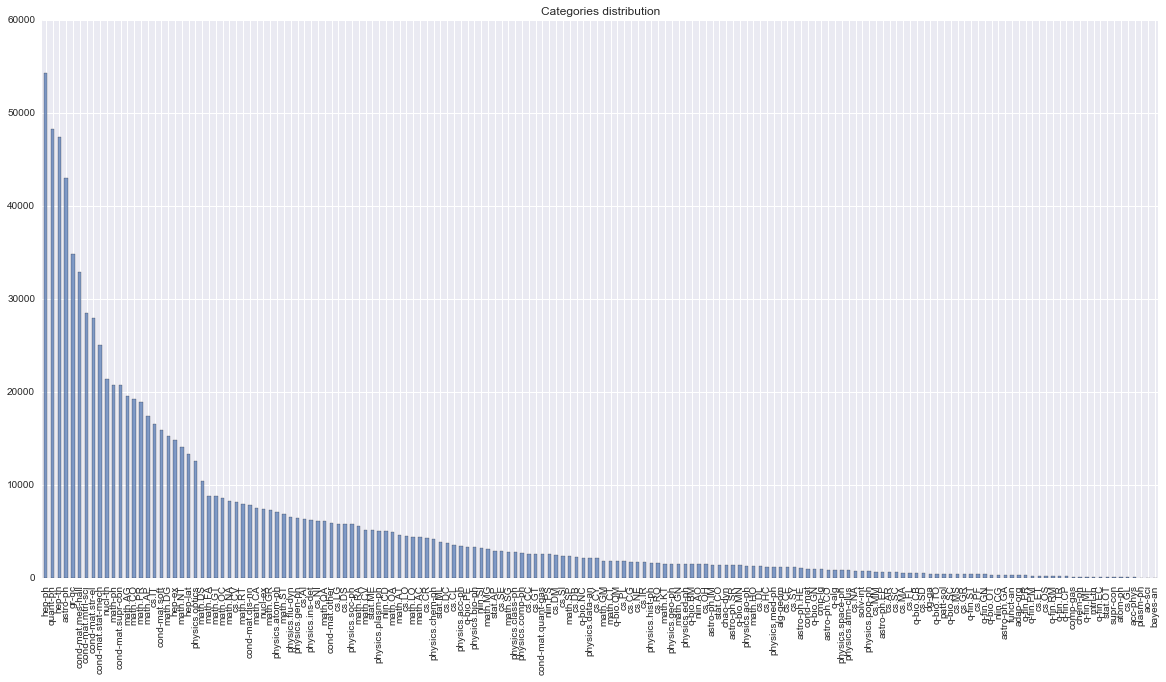

In [6]:
plt.figure(figsize=(20,10))
queries.primary_category.value_counts().plot(kind='bar', alpha=0.7)
plt.title("Categories distribution")
plt.show()

Распределение имеет длинный хвост -- это категории, которые покрывают небольшое количество статей. Выполним отсечение по медиане.

In [7]:
median = np.median(queries.primary_category.value_counts())
cat_count = dict(queries.primary_category.value_counts())
selected = []

for cat in cat_count.keys():
    if cat_count[cat] > median:
        selected.append(cat)
        
queries = queries[queries.primary_category.isin(selected)]

После того как были выброшены редкие категории, распределение приобрело следующий вид

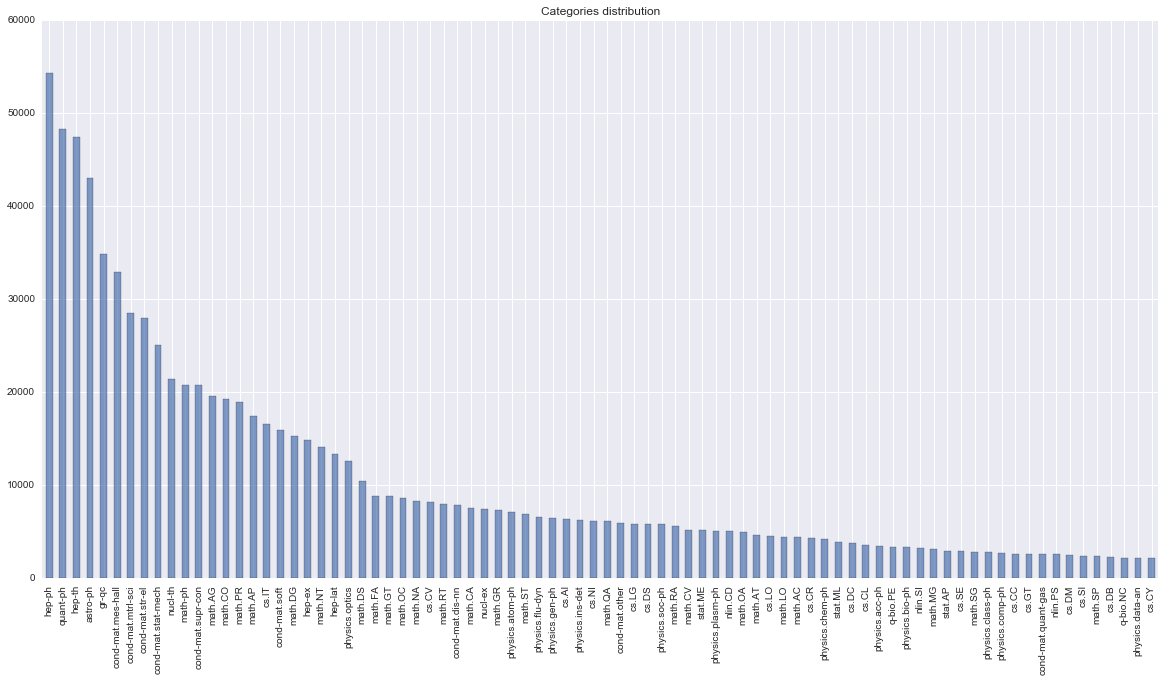

In [8]:
plt.figure(figsize=(20,10))
queries.primary_category.value_counts().plot(kind='bar', alpha=0.7)
plt.title("Categories distribution")
plt.show()

Заменяем "/" на "_" в поле id

In [67]:
indexes = list(queries.index)
for i, ind in enumerate(queries.index):
    new_ind = ind.replace('/','_')
    indexes[i] = new_ind

In [68]:
queries.set_index(np.array(indexes), inplace=True)

В списке category встречаются неизвестные названия категорий, которые сложно интерепретировать, например, 'I.2.6; K.3.2'. Удалим эти метки из category.

In [71]:
%%time
for i in range(len(queries)):
    
    cat_list = []
    c_list = queries.iloc[i].category
    
    if type(c_list) == str:
        cat = eval(c_list)
        if len(cat) == 1:
            cat_list = cat
        else:
            for c in cat:
                if c in set(selected):
                    cat_list.append(c)
        queries.iloc[i].category = cat_list
        if i%100000 == 0:
            print("%d iterations" % i)

0 iterations
100000 iterations
200000 iterations
300000 iterations
400000 iterations
500000 iterations
600000 iterations
700000 iterations
800000 iterations
Wall time: 11min 11s


In [72]:
queries.head()

,title,primary_category,category,source_link,pdf_link
0710.3447v1,Problems of Testology,stat.AP,[stat.AP],http://arxiv.org/e-print/0710.3447v1,http://arxiv.org/pdf/0710.3447v1
0907.2480v1,Thoughts on new statistical procedures for age...,stat.AP,"[stat.AP, stat.ME]",http://arxiv.org/e-print/0907.2480v1,http://arxiv.org/pdf/0907.2480v1
1108.0301v1,On the Concept of Snowball Sampling,stat.AP,[stat.AP],http://arxiv.org/e-print/1108.0301v1,http://arxiv.org/pdf/1108.0301v1
1203.1421v1,A note on characterization based on past entropy,stat.AP,[stat.AP],http://arxiv.org/e-print/1203.1421v1,http://arxiv.org/pdf/1203.1421v1
1012.4702v1,Experience Rating with Poisson Mixtures,stat.AP,[stat.AP],http://arxiv.org/e-print/1012.4702v1,http://arxiv.org/pdf/1012.4702v1


Посмотрим к какому количеству тем относятся документы.

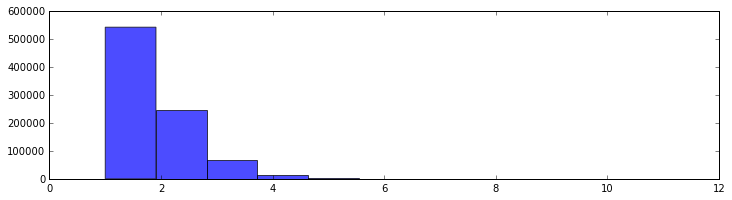

Максимальное число тем: 11
Минимальное число тем: 1
Среднее число тем: 1.497


In [73]:
freq = []
for i in list(queries.category):
    freq.append(len(i))

plt.figure(figsize=(12,3))
plt.hist(freq, alpha=0.7, bins=11)
plt.show()

print("Максимальное число тем: %d" % max(freq))
print("Минимальное число тем: %d" % min(freq))
print("Среднее число тем: %.3f" % np.mean(freq))

In [77]:
queries.primary_category.value_counts().tail()

math.SP            2358
cs.DB              2213
q-bio.NC           2165
physics.data-an    2140
cs.CY              2106
Name: primary_category, dtype: int64

In [78]:
queries.head()

,title,primary_category,category,source_link,pdf_link
0710.3447v1,Problems of Testology,stat.AP,[stat.AP],http://arxiv.org/e-print/0710.3447v1,http://arxiv.org/pdf/0710.3447v1
0907.2480v1,Thoughts on new statistical procedures for age...,stat.AP,"[stat.AP, stat.ME]",http://arxiv.org/e-print/0907.2480v1,http://arxiv.org/pdf/0907.2480v1
1108.0301v1,On the Concept of Snowball Sampling,stat.AP,[stat.AP],http://arxiv.org/e-print/1108.0301v1,http://arxiv.org/pdf/1108.0301v1
1203.1421v1,A note on characterization based on past entropy,stat.AP,[stat.AP],http://arxiv.org/e-print/1203.1421v1,http://arxiv.org/pdf/1203.1421v1
1012.4702v1,Experience Rating with Poisson Mixtures,stat.AP,[stat.AP],http://arxiv.org/e-print/1012.4702v1,http://arxiv.org/pdf/1012.4702v1


In [79]:
# Записываем результат

queries.to_csv(path + 'unique_queries.csv', index_label='id')

Файл доступен по [ссылке](https://drive.google.com/open?id=0B_NefGKQ1pCsZjhzUFNTdnJPZlE)

## Скачивание статей на диск

Около 60 тысяч документов может быть получено в результате прямого скачивания архивов [KDD Cap 2003](http://www.cs.cornell.edu/projects/kddcup/datasets.html)

Укажем путь, куда будут загружаться статьи

In [9]:
path_to_sources = 'C:/Users/user/Downloads/arxiv/source/'

Используем полученный ранее [файл](https://drive.google.com/open?id=0B_NefGKQ1pCsZjhzUFNTdnJPZlE) с метаданными статей для загрузки файлов на диск. Будем загружать только исходники, потому что  их проще обрабатывать (исходники записаны с формате tex, который имеет опреденную структуру и удобен для текстовой обработки).

Экспорт метаданных

In [3]:
queries = pd.read_csv(path + "unique_queries.csv", encoding='cp1251', index_col='id')
queries.head()

,title,primary_category,category,source_link,pdf_link
id,,,,,
0710.3447v1,Problems of Testology,stat.AP,['stat.AP'],http://arxiv.org/e-print/0710.3447v1,http://arxiv.org/pdf/0710.3447v1
0907.2480v1,Thoughts on new statistical procedures for age...,stat.AP,"['stat.AP', 'stat.ME']",http://arxiv.org/e-print/0907.2480v1,http://arxiv.org/pdf/0907.2480v1
1108.0301v1,On the Concept of Snowball Sampling,stat.AP,['stat.AP'],http://arxiv.org/e-print/1108.0301v1,http://arxiv.org/pdf/1108.0301v1
1203.1421v1,A note on characterization based on past entropy,stat.AP,['stat.AP'],http://arxiv.org/e-print/1203.1421v1,http://arxiv.org/pdf/1203.1421v1
1012.4702v1,Experience Rating with Poisson Mixtures,stat.AP,['stat.AP'],http://arxiv.org/e-print/1012.4702v1,http://arxiv.org/pdf/1012.4702v1


Скачивание документов

In [37]:
def get_articles(queries=queries, category='stat.AP', limit=1000):
    '''
    Description
    '''
    metadata = queries[queries.primary_category == category]
    n = len(metadata)
    arxiv_id = metadata.index
    sources = metadata.source_link
    categories = metadata.primary_category.unique()
    WAIT_TIME = 3
    ANTI_BAN_TIME = 3 * 60
    k = 0                                                             # count new files
    
    for i,ind in enumerate(arxiv_id):
        filename = path_to_sources + ind  
            
        if os.path.isfile(filename):                                  # check existing
            print("File %s already exist" % ind)
        
        else:
            try:
                urlretrieve(sources[i], filename)                     # downloading file
                k += 1
                
                if k % 10 == 1:
                    time.sleep(WAIT_TIME) 
                    print("Loaded %d files" % k)
                if k % 1000 == 500:
                    time.sleep(ANTI_BAN_TIME) 
                    print("Antiban. 3 min waiting..." % k)
                if k > limit:
                    break
                
            except Exception:
                print("Error") 

Список всех категорий

In [34]:
cat_count = dict(queries.primary_category.value_counts())
cat_count

{'astro-ph': 43003,
 'cond-mat.dis-nn': 7868,
 'cond-mat.mes-hall': 32910,
 'cond-mat.mtrl-sci': 28484,
 'cond-mat.other': 5903,
 'cond-mat.quant-gas': 2555,
 'cond-mat.soft': 15845,
 'cond-mat.stat-mech': 25021,
 'cond-mat.str-el': 27909,
 'cond-mat.supr-con': 20700,
 'cs.AI': 6275,
 'cs.CC': 2607,
 'cs.CL': 3502,
 'cs.CR': 4308,
 'cs.CV': 8168,
 'cs.CY': 2106,
 'cs.DB': 2213,
 'cs.DC': 3760,
 'cs.DM': 2419,
 'cs.DS': 5810,
 'cs.GT': 2562,
 'cs.IT': 16554,
 'cs.LG': 5835,
 'cs.LO': 4491,
 'cs.NI': 6160,
 'cs.SE': 2865,
 'cs.SI': 2395,
 'gr-qc': 34868,
 'hep-ex': 14822,
 'hep-lat': 13284,
 'hep-ph': 54280,
 'hep-th': 47397,
 'math-ph': 20773,
 'math.AC': 4368,
 'math.AG': 19545,
 'math.AP': 17439,
 'math.AT': 4560,
 'math.CA': 7461,
 'math.CO': 19248,
 'math.CV': 5183,
 'math.DG': 15215,
 'math.DS': 10393,
 'math.FA': 8830,
 'math.GR': 7294,
 'math.GT': 8783,
 'math.LO': 4437,
 'math.MG': 3106,
 'math.NA': 8272,
 'math.NT': 14098,
 'math.OA': 4968,
 'math.OC': 8554,
 'math.PR': 18905,


Выбираем категорию, запускаем процесс скачивания

In [10]:
print("Loading category %s..." % 'cs.AI')
%time get_articles(category='cs.AI')

Loading category cs.AI...


>**Замечание!**  
Процесс скачивания занимает много времени. Средняя скорость загрузки составила ~10000 статей в сутки. Всего таким образом было скачано более 160 тысяч статей.